# "Authorship Identification: Part-1 (The baseline)"
> "Given a large number of authors of texts, the goal is to correctly identify the author of a given text. This problem is considered hard especially when less data is available and texts are small (typically with 500 words or less). In this part I have setup BiLSTM model as baseline for the task."

- toc: false
- sticky_rank: 1
- branch: master
- badges: true
- comments: true
- categories: [project, machine-learning, notebook, python]
- image: images/vignette/base.jpg
- hide: false
- search_exclude: false

# Abstract
Authorship identification is the task of identifying the author of a given text from a set of suspects. The main concern of this task is to define an appropriate characterization of texts that captures the writing style of authors.<br/>
As a published author usually has a unique writing style in his/her work. The writing style is mostly context independ and is discernible by a human reader.<br/>
In previous studies various stylometric models have been suggested for the aforementioned task e.g. BiLSTM, SVM, Logistic Regression, several other Deep Learning Models. But most of them fail or show poor results for either short passages or long passages and none of them were able to perform well in both cases.<br/>
*Previously the best performance at authroship identification is achieved by LSTM and GRU model*.<br/>

## Baseline Model
For setting up a baseline for the task, I used a **combination of stack of 1D-CNN with BiLSTM** which gives a **validation accuracy: ~62% and test accuracy: ~54%** while using a fairly simple BiDirectional LSTM and CNN Architecture. And unsurprisingly the results of baseline model are pretty close to the past best performing model without any type of Tuning.

Model uses pretrained GloVe word Embeddings for text representation. GloVe uncased word embeddings were trained using Wikipedia 2014 + Gigaword 5 and it consists of 6B tokens, 400K vocab. Embeddings are available as 50d, 100d, 200d, & 300d vectors. [[Source]](http://nlp.stanford.edu/data/glove.6B.zip)

>In most of the cases training word embeddings for the downstream task is a good idea and gives better results, albeit because of computational requirements I have used pretrained GloVE embeddings.

# Utilitiy functions
These are the functions that I'll be using to do redundant tasks in this part like:
1. Plotting train history
2. Saving figures
3. Saving and Loading pickle objects

take a look if interested!

In [1]:
#collapse
import matplotlib.pyplot as plt
import numpy as np
import pickle
from pathlib import Path
import keras

def save_object(obj: object, file_path: Path) -> None:
    """
    Save a python object to the disk and creates the file if does not exists already.
    Args:
        file_path - Path object for pkl file location
        obj       - object to be saved

    Returns:
        None
    """
    if not file_path.exists():
        file_path.touch()
        print(f"pickle file {file_path.name} created successfully!")
    else:
        print(f"pickle file {file_path.name} already exists!")

    with file_path.open(mode='wb') as file:
        pickle.dump(obj, file, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"object {type(obj)} saved to file {file_path.name}!")


def load_object(file_path: Path) -> object:
    """
    Loads the pickle object file from the disk.
    Args:
        file_path - Path object for pkl file location

    Returns:
        object
    """
    if file_path.exists():
        with file_path.open(mode='rb') as file:
            print(f"loaded object from file {file_path.name}")
            return pickle.load(file)
    else:
        raise FileNotFoundError


def vectorize_sequence(sequences: np.ndarray, dimension: int = 10000):
    """
    Convert sequences into one-hot encoded matrix of dimension [len(sequence), dimension]

    Args: 
        sequences - ndarray of shape [samples, words]
        dimension = number of total words in vocab
    Return:
        vectorized sequence of shape [samples, one-hot-vecotor]
    """
    # Create all-zero matrix
    results = np.zeros((len(sequences), dimension))

    for (i, sequence) in enumerate(sequences):
        results[i, sequence] = 1.

    return results


def plot_history(
    history:  keras.callbacks.History,
    metric:  str = 'acc',
    save_path: Path = None,
    model_name: str = None
) -> None:
    """
    Plots the history of training of a model during epochs

    Args: history:
        model history - training history of a model
        metric - 

    Plots:
    1. Training and Validation Loss
    2. Training and Validation Accuracy
    """
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(history.epoch, history.history.get(
        'loss'), "o", label='train loss')
    ax1.plot(history.epoch, history.history.get(
        'val_loss'), '-', label='val loss')
    ax2.plot(history.epoch, history.history.get(
        metric), 'o', label='train acc')
    ax2.plot(history.epoch, history.history.get(
        f"val_{metric}"), '-', label='val acc')
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("loss")
    ax2.set_xlabel("epoch")
    ax2.set_ylabel("accuracy")
    ax1.set_title("Loss")
    ax2.set_title("Accuracy")
    f.suptitle(f"Training History: {model_name}")
    ax1.legend()
    ax2.legend()
    if save_path is not None:
        f.savefig(save_path)

# Structure of notebook
1. [Data Preprocessing](#Data-Preprocessing)<br/>
    a. [Load dataset](#Load-Dataset)<br/>
    b. [Text Vectorization](#Text-Vectorization)<br/>
    c. [Configure Dataset for faster training](#Configure-dataset)<br/>
    <br/>
2. [Modelling](#Modelling)<br/>
    a. [Parse Glove Embeddings](#Embedding-parsing)<br/>
    b. [Define ConvnetBiLSTM model](#Model)<br/>
    c. [Load Embedding matrix](#load-embedding-matrix)<br/>
    <br/>
3. [Training and Evaluation](#Training-and-Evaluation)

# Data Preprocessing
Dataset: UCI C50 Dataset(small subset of origin RCV1 dataset) [[Source]](https://archive.ics.uci.edu/ml/datasets/Reuter_50_50#)
C50 dataset is widely used for authorship identification.<br/>
Dataset Specifications:
>Catagories/Authors: 50 <br/>
>Datapoints per class: 50 <br/>
>Total Datapoints: 5000 (4500 train, 500 test)

## Loading and Preprocessing the dataset
1. 80-20 train and validation split and 500 holdout datapoints.<br/>
2. I'll use `text_dataset_from_directory` utility of keras library to load dataset which is faster than manually reading the text.<br/>
3. In the preprocessing step, numbers and special characters except `{.} {,} and {'}` are removed from the dataset.

In [48]:
# collapse
# Import Python Regular Expression library
import re

src_dir = Path('data/C50_raw/')
src_test_dir = src_dir / 'test'
src_train_dir = src_dir / 'train'

dst_dir = Path('data/C50/')
dst_test_dir = dst_dir / 'test'
dst_train_dir = dst_dir / 'train'


test_sub_dirs = src_test_dir.iterdir()
train_sub_dirs = src_train_dir.iterdir()

for i, author in enumerate(test_sub_dirs):
    author_name = author.name
    dst_author = dst_test_dir / author_name
    dst_author.mkdir()
    for file in author.iterdir():
        file_name = file.name
        dst = dst_author / file_name
        raw_text = file.read_text(encoding='utf-8')
        out_text = re.sub("[^A-Za-z.',]+", " ", raw_text)
        dst.write_text(out_text, encoding='utf-8')

for i, author in enumerate(train_sub_dirs):
    author_name = author.name
    dst_author = dst_train_dir / author_name
    dst_author.mkdir()
    for file in author.iterdir():
        file_name = file.name
        dst = dst_author / file_name
        raw_text = file.read_text(encoding='utf-8')
        out_text = re.sub("[^A-Za-z.',]+", " ", raw_text)
        dst.write_text(out_text, encoding='utf-8')

In [57]:
# collapse
nfiles_test = len(list(dst_test_dir.glob("*/*.txt")))
nfiles_train = len(list(dst_train_dir.glob("*/*.txt")))
print(f"Number of files in processed test dataset: {nfiles_test}")
print(f"Number of files in processed train dataset: {nfiles_train}")

Number of files in processed test dataset: 500
Number of files in processed train dataset: 4500


## Load Dataset

In [2]:
#collapse
import keras
import numpy as np
import tensorflow as tf
from keras import models, layers
from keras.preprocessing import text_dataset_from_directory
from keras.layers.experimental.preprocessing import TextVectorization
import keras.callbacks as cb

ds_dir = Path('data/C50/')
train_dir = ds_dir / 'train'
test_dir = ds_dir / 'test'
seed = 123
batch_size = 32

train_ds = text_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    seed=seed,
    shuffle=True,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training'
)

val_ds = text_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    seed=seed,
    shuffle=True,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation')

test_ds = text_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    seed=seed,
    shuffle=True,
    batch_size=batch_size)

Found 4500 files belonging to 50 classes.
Using 3600 files for training.
Found 4500 files belonging to 50 classes.
Using 900 files for validation.
Found 500 files belonging to 50 classes.


## Inspect dataset

In [3]:
class_names = test_ds.class_names
class_names = np.asarray(class_names)
print(f"nclasses: {len(class_names)}")
print(f'first 4 classes/users: {class_names[:4]}')
for texts, labels in train_ds.take(1):
    print("Shape of texts", texts.shape)
    print(f'Class of 2nd data point: {class_names[labels.numpy()[1].astype(bool)]}')

nclasses: 50
first 4 classes/users: ['AaronPressman' 'AlanCrosby' 'AlexanderSmith' 'BenjaminKangLim']
Shape of texts (32,)
Class of 2nd data point: ['GrahamEarnshaw']


In [4]:
#collapse
MAX_LEN_TRAIN = 0
MAX_LEN_TEST = 0
for file in test_dir.glob('*/*.txt'):
    with file.open() as f:
        seq_len = 0
        for line in f.readlines():
            seq_len += len(line.split())
#         print(seq_len)
        if MAX_LEN_TEST < seq_len:
            MAX_LEN_TEST = seq_len
for file in train_dir.glob('*/*.txt'):
    with file.open() as f:
        seq_len = 0
        for line in f.readlines():
            seq_len += len(line.split())
#         print(seq_len)
        if MAX_LEN_TRAIN < seq_len:
            MAX_LEN_TRAIN = seq_len
print(f"length of largest article in train dataset: {MAX_LEN_TRAIN}")
print(f"length of largest article in test dataset: {MAX_LEN_TEST}")

length of largest article in train dataset: 1498
length of largest article in test dataset: 1474


In [61]:
#collapse
for batch, label in iter(val_ds):
    index = np.argmax(label.numpy(), axis=1).astype(np.int)
    print(f'Users of first batch: {class_names[index]}')
    break

Users of first batch: ['BradDorfman' 'JaneMacartney' 'RobinSidel' 'JanLopatka' 'GrahamEarnshaw'
 'SamuelPerry' 'KouroshKarimkhany' "LynneO'Donnell" 'JaneMacartney'
 'FumikoFujisaki' 'MarkBendeich' 'LynnleyBrowning' 'JanLopatka'
 'EdnaFernandes' 'SimonCowell' 'KirstinRidley' 'MatthewBunce'
 'MichaelConnor' 'KeithWeir' 'HeatherScoffield' 'MarcelMichelson'
 'PatriciaCommins' 'MureDickie' 'TanEeLyn' 'MichaelConnor' 'MureDickie'
 'MartinWolk' 'TanEeLyn' 'ScottHillis' 'KirstinRidley' 'ToddNissen'
 'MichaelConnor']


## Text Vectorization
Text vectorization includes the following tasks using `TextVectorization` layer:
1. `Standardization`
2. `Tokenization`
3. `Vectorization`

### Initial run of the vectorization layers
1. Make a text-only dataset (without labels), then call adapt
2. Do not call adapt on test dataset to prevent data-leak
3. train and save vocab to disk

Note: Use it only for the first time or if vocab is not saved

In [5]:
#collapse
from utils import save_object

### Define vectorization layers
VOCAB_SIZE = 34000
MAX_LEN = 1450

vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_LEN
)

# Train the layers to learn a vocab
train_text = train_ds.map(lambda text, lables: text)
vectorize_layer.adapt(train_text)


# Save the vocabulary to disk
# Run this cell for the first time only
vocab = vectorize_layer.get_vocabulary()
vocab_path = Path('vocab/vocab_C50.pkl')
save_object(vocab, vocab_path)
vocab_len = len(vocab)
print(f"vocab size of vectorizer: {vocab_len}")

pickle file vocab_C50.pkl already exists!
object <class 'list'> saved to file vocab_C50.pkl!
vocab size of vectorizer: 34000


### Vectorization layers from saved vocab
Only run after first saving the vocabulary to the disk!

In [63]:
# collapse
# # Load vocab
# from utils import load_object
# vocab_path = Path('vocab/vocab_C50.pkl')
# vocab = load_object(vocab_path)

# VOCAB_SIZE = 34000
# MAX_LEN  = 1500

# vectorize_layer = TextVectorization(
#     max_tokens=VOCAB_SIZE, 
#     output_mode='int',
#     output_sequence_length=MAX_LEN,
#     vocabulary=vocab
# )

## Configure dataset
This is the final step of the data-processing pipeline where the text is converted into vectors, and then to train the model faster, dataset is prefetched and cached before each epoch.
**Prefetch is especially efficient when training on a GPU** as the CPU fetch and cache the dataset while GPU is training in parallel and after finishing current epoch GPU doesn't have to wait for CPU to load the data for next epoch.

In [6]:
def vectorize(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

AUTOTUNE = tf.data.AUTOTUNE
def prepare(ds):
    return ds.cache().prefetch(buffer_size=AUTOTUNE)

train_ds = train_ds.map(vectorize)
val_ds = val_ds.map(vectorize)
test_ds = test_ds.map(vectorize)

# Configure the datasets for fast training 
train_ds = prepare(train_ds)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

# Modelling

Now comes the most interesting part!<br/>
Below cell first creates an `emb_index` dictionary which **maps words to a 100-Dimensional embedding vector** and then `emb_matrix` is created which maps each word in **C50 vocab** to corresponding embedding. 

In [8]:
##### Pretrained Glove Embeddings #####
## Parse the weights
from utils import load_object
emb_dim = 100
glove_file = Path(f'vocab/glove/glove.6B.{emb_dim}d.txt')
emb_index = {}
with glove_file.open(encoding='utf-8') as f:
    for line in f.readlines():
        values = line.split()
        word = values[0]
        coef = values[1:]
        emb_index[word] = coef

##### Getting embedding weights #####
vocab = load_object(Path('vocab/vocab_C50.pkl'))
emb_matrix = np.zeros((VOCAB_SIZE, emb_dim))
for index, word in enumerate(vocab):
    # get coef of word
    emb_vector = emb_index.get(word)
    if emb_vector is not None:
        emb_matrix[index] = emb_vector
print(f"Embedding Dimensionality: {emb_matrix.shape}")

loaded object from file vocab_C50.pkl
Embedding Dimensionality: (34000, 100)


In [26]:
import keras.backend as K
from keras.utils import plot_model
from keras import regularizers
K.clear_session()

lstm_model = models.Sequential([
    layers.Embedding(VOCAB_SIZE, emb_dim, input_shape=(MAX_LEN,)),
    layers.SpatialDropout1D(0.3),
    layers.Conv1D(256, 11, activation='relu'),
    layers.MaxPooling1D(7),
    layers.Dropout(0.4),
    layers.BatchNormalization(),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Conv1D(128, 3, activation='relu'),
    layers.MaxPooling1D(3),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Conv1D(64, 3, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    layers.BatchNormalization(),
    layers.Dense(50, activation='softmax')
])

## Detailed Architecture of the model 
Load the `emb_matrix` as wieghts of the embedding layer of model and then set them as non-trainable.

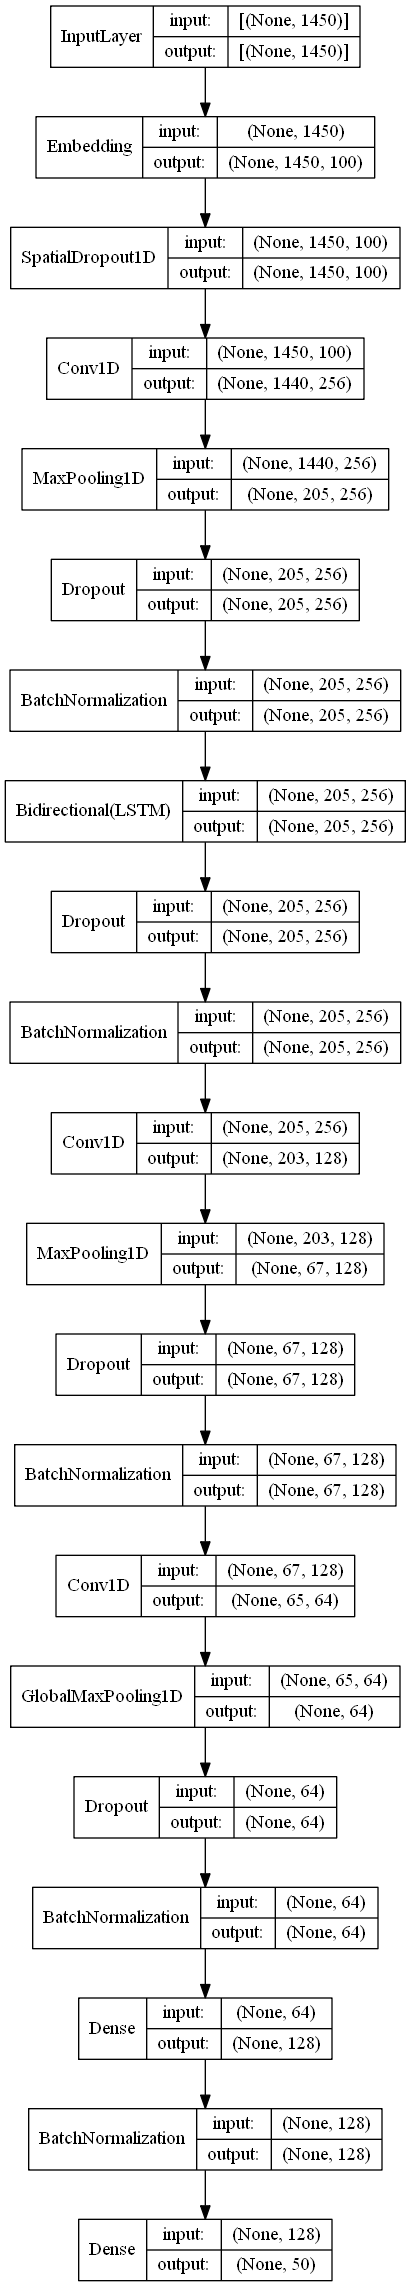

In [27]:
lstm_model.layers[0].set_weights([emb_matrix])
lstm_model.layers[0].trainable = False
plot_model(lstm_model, show_layer_names=False, show_shapes=True, to_file="models/base.png")

# Training the model

In [28]:
# from keras.optimizers import RMSprop

K.clear_session()
# optim = RMSprop(lr=1e-2)

################# Configure Callbacks #################
# Early Stopping
es = cb.EarlyStopping(
    monitor='val_loss',
    min_delta=5e-4,
    patience=5,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

# ReduceLROnPlateau
reduce_lr = cb.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.4,
    patience=3,
    verbose=1,
    mode='auto',
    min_delta=5e-3,
    min_lr=1e-6
)

# Tensorboard
tb = cb.TensorBoard(
    log_dir="./logs",
    write_graph=True,
)


################# Model Training #################
lstm_model.compile(
    loss='CategoricalCrossentropy',
    optimizer='adam',
    metrics=['acc']
)

lstm_history = lstm_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[es, reduce_lr, tb]
)

lstm_model.save('models/base.h5')

Epoch 1/100
113/113 [==============================] - 35s 220ms/step - loss: 4.5336 - acc: 0.0188 - val_loss: 3.9713 - val_acc: 0.0200
Epoch 2/100
113/113 [==============================] - 13s 114ms/step - loss: 4.2080 - acc: 0.0312 - val_loss: 3.8599 - val_acc: 0.0278
Epoch 3/100
113/113 [==============================] - 13s 116ms/step - loss: 3.8997 - acc: 0.0403 - val_loss: 3.5842 - val_acc: 0.0544
Epoch 4/100
113/113 [==============================] - 13s 118ms/step - loss: 3.6826 - acc: 0.0454 - val_loss: 3.4762 - val_acc: 0.0467
Epoch 5/100
113/113 [==============================] - 13s 118ms/step - loss: 3.4679 - acc: 0.0585 - val_loss: 3.2102 - val_acc: 0.0900
Epoch 6/100
113/113 [==============================] - 13s 119ms/step - loss: 3.2866 - acc: 0.0862 - val_loss: 3.1259 - val_acc: 0.0844
Epoch 7/100
113/113 [==============================] - 13s 119ms/step - loss: 3.1113 - acc: 0.0972 - val_loss: 2.9419 - val_acc: 0.1533
Epoch 8/100
113/113 [===========================

Model evaluation on test dataset
16/16 [==============================] - 1s 58ms/step - loss: 1.4009 - acc: 0.5360


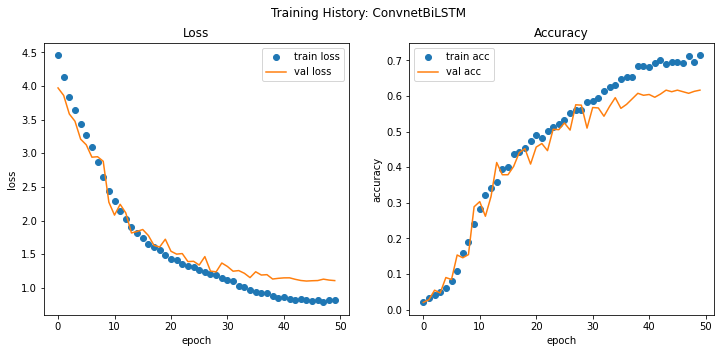

In [29]:
# Model evaluation
print('Model evaluation on test dataset')
lstm_model.evaluate(test_ds)

# Plot training history
plot_history(
    lstm_history,
    model_name="ConvnetBiLSTM",
    save_path=Path('plots/base.jpg')
)

# Summary

The simple BiLSTM + Conv1D model performs fairly well considering that it was not tuned for performance and provides a good baseline to work with. A clear thing to note here is that, While performance of the model on validation dataset is quite good but it performs poorly on the test. Model doesn't generalize well on the holdout dataset which is our primary goal, in the text part I'll try to improve the accuracy to make it better than the baseline. 